In [3]:
#%%bash 
#export SUDO_ASKPASS=/Applications/Utilities/XQuartz.app/Contents/MacOS/X11
#ln -sfhv /Library/Frameworks/R.framework/Versions/3.3 /Library/Frameworks/R.framework/Versions/Current

In [19]:
import sys
import os

#%load_ext rpy2.ipython
#%R require(ggplot2)

In [20]:
from deeplate.MMdata import MMData 
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.ndimage as nd

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
import pandas as pd

In [21]:
import deeplate.platesegmenter as ps

In [22]:
#folder = '/Volumes/MusiqueHD/201710126_lowerbound'
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound/'

In [58]:
#weights_folder  = '/Users/guillaume/Desktop/PostdocBasel/PlateSegmenter_Python_Git/DeepPlate/Learn201710126/'
weights_folder  = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_subsetrot/'

In [24]:
folder_to_save = '/scicore/home/nimwegen/witzg/DeepPlateAnalysis/'

In [25]:
MMobj = MMData(folder = folder)
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [26]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [72]:
#load deep learning model and weights
plate_model = ps.get_unet(1, MMobj.height,MMobj.width)
plate_model.load_weights(weights_folder+'weights.h5')

In [28]:
#load training examples to get normalization
imgs_train, imgs_mask_train, imgs_weight_train = ps.load_train_data(weights_folder)

In [60]:
#get metadata
z_step = MMobj.get_zstep()
positions, well = MMobj.get_position_names()
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
well_str = well[well_index]

In [74]:
positions.index("C3-Site_1")

41

1/1 [==============================] - 11s 11s/step


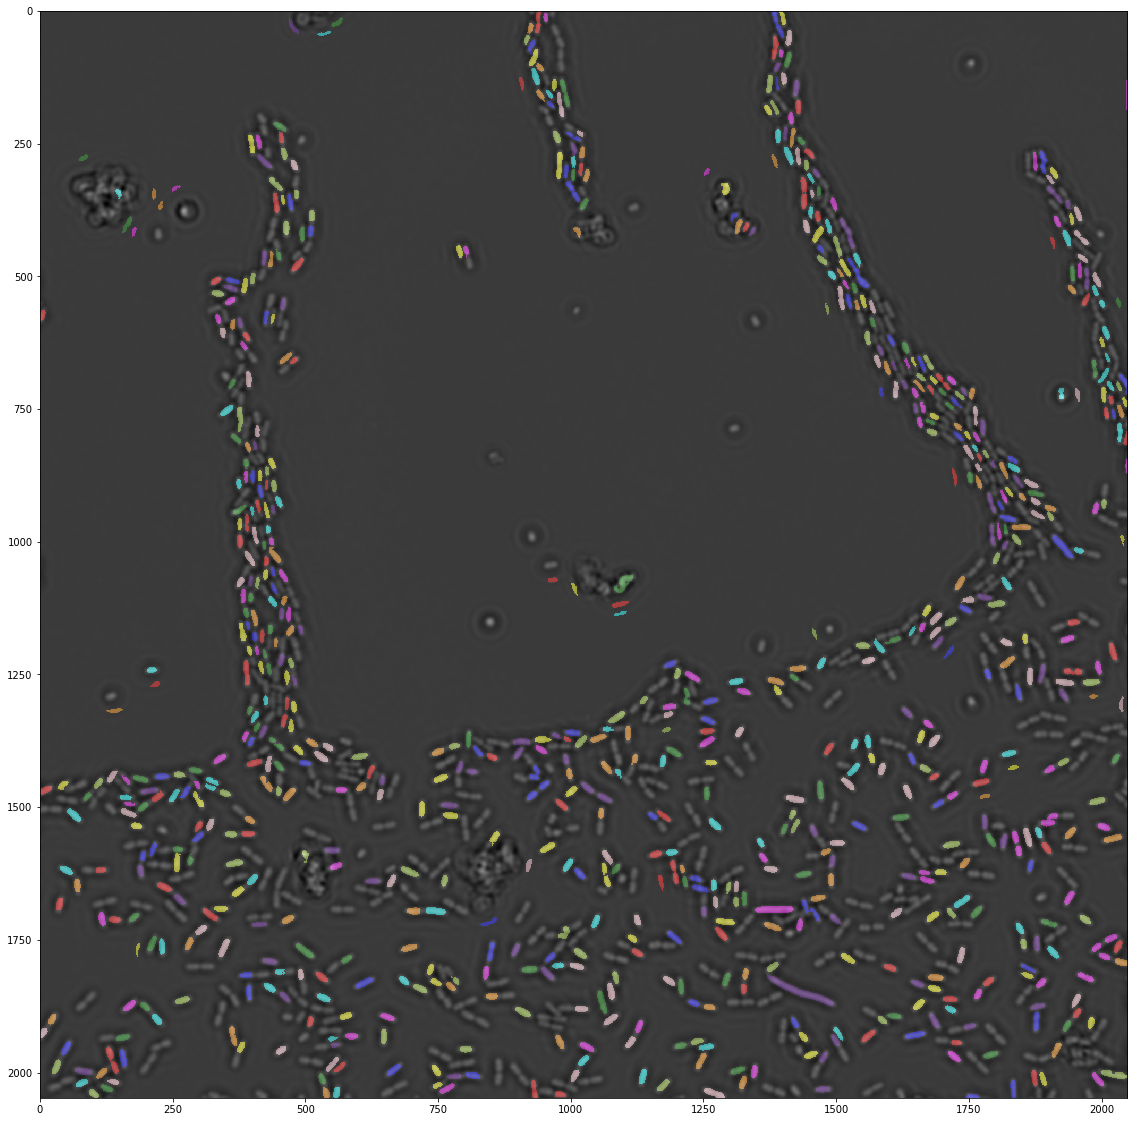

In [101]:
#create folder to save data
if not os.path.exists(folder_to_save):
    os.makedirs(folder_to_save)

#do the segmentation
for i in range(41,42):#range(len(positions)):
    
    #load bf stack
    stack = MMobj.get_stack(frame=0,channel=bf_ch,position=i, compress = 1)
    
    #calculate correlation image
    correlated_norm = ps.phase_corr_simple(stack,thickness=800,z_step=z_step)
    correlated_norm_gauss = nd.gaussian_filter(correlated_norm,3)
    
    #deep-segment image
    plate_im = correlated_norm_gauss.astype('float32')#-np.mean(imgs_train)
    plate_im = plate_im#/np.std(imgs_train)
    plate_im = plate_im[np.newaxis,...,np.newaxis]
    plate_im_mask = plate_model.predict(plate_im, verbose=1)
    plate_im_mask = np.reshape(plate_im_mask,correlated_norm.shape)
    
    #threshold deepe learning segmentation and clean resulting mask
    plate_im_mask2 = plate_im_mask.copy()
    plate_im_mask2[plate_im_mask2<0.1]=0
    plate_im_mask2[plate_im_mask2>0.1]=1

    masklab = morphology.label(plate_im_mask2)
    cellinfo = regionprops(masklab)
    newMask = np.zeros(masklab.shape)
    for c in cellinfo:
        if (c.label>0)&(c.area>100)&(c.area<10000)&(c.solidity>0.8)&(c.eccentricity>0.6):
            newMask[masklab==c.label]=1
    
    #load fluo image
    im_fluo = MMobj.get_stack(frame=0,channel=fluo_ch,position=i, compress = 1)[:,:,0]
    #calculate local properties
    cell_info = regionprops(label(newMask),im_fluo)
    
    mean_int = [x.mean_intensity for x in cell_info]
    posx = [x.centroid[0] for x in cell_info]
    posy = [x.centroid[1] for x in cell_info]
    #create a dataframe
    cell_struct = {'mean_fluo':mean_int,'posx': posx, 'posy': posy}
    cell_frame = pd.DataFrame(cell_struct)
    
    cell_frame.to_csv(folder_to_save+positions[i]+'.csv')
    
    #save image
    fig, ax = plt.subplots(figsize=(20,20))
    plt.imshow(correlated_norm_gauss,cmap='gray')
    plt.imshow(label2rgb(label(newMask),bg_label=0),alpha = 0.4)
    plt.show()
    fig.savefig(folder_to_save+positions[i]+'seg.png')

/scicore/home/nimwegen/witzg/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


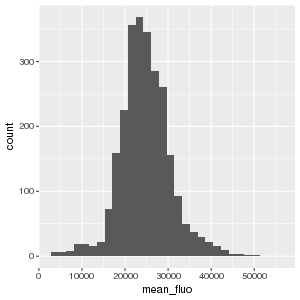

In [18]:
%%R -i cell_frame,folder_to_save -w 300 -h 300 -u px
x<-ggplot(NULL)+
geom_histogram(data=cell_frame,aes(x=mean_fluo))
print(x)

#location<-paste(folder_to_save,cell_frame[0,'position'],'.Rda',sep = "")
#save(cell_frame,file=location)